# Zvonimir's suggestion

Notes:

We will just take the simple step of adding a column to the pktable doing what zvonimir suggests for P_IR,lin.
Then will add a parameter $\alpha$ from the outside as a transfer function approach.
He also suggested exponential regulator but I think this is already built into CLEFT via cutoff.

Need to replace
\begin{equation}
P_{zel} = \int d^3 q e^{- i k_i k_j A_{ij} (q) },
\end{equation}

(with A_ij  being the displacement difference cumulant.)
with
\begin{equation}
P_{lin,IR} = \int d^3 q \xi_{lin} (q) e^{- i k_i k_j A_{ij} (q) },
\end{equation}

Code changes:
- Changed to two power components (first is L,IR, second is ZA)
- Set bias_integrands[-2,:] to multiply the Zeldovich integral by $\xi_{L}$
- Need expanded k range in cleft, bumping up cutoff to 40 so we don't lose so much at high k seems to work- this should be okay since kint extends to 1e3. Probably should've done this for ZA before but I guess numerically it worked out that it was already small enough to be unnoticable?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from gzpt import hzpt
# from gzpt.zel import *
# from gzpt.matter import Correlator

In [2]:
# from nbodykit import cosmology
# klin = np.logspace(-3,1,10000)
# plin0 = cosmology.LinearPower(cosmology.Planck15,0.0)(klin)

In [3]:
# np.savetxt('./tests/test_plin_planck_z0.0.txt',np.transpose([klin,plin0]))

In [4]:
# klin,plin = np.loadtxt('./tests/test_plin_planck_z0.55.txt',unpack=True) #load some input linear power
# model = hzpt(klin,plin) #instantiate the hzpt model (at the plin cosmology)
klin,plin = np.loadtxt('./tests/test_plin_planck_z0.0.txt',unpack=True) #load some input linear power


# mm = Correlator([2,350,30,10,25,4],model)

In [5]:
klin.max()

10.0

In [6]:
from gzpt import zel

irlin branch


In [7]:
cleft = zel.CLEFT(klin,plin)

In [8]:
np.exp(np.array([-50*-70],dtype=np.float128)),np.exp(-10*-70),

(array([1.07321482e+1520], dtype=float128), 1.0142320547350045e+304)

In [9]:
cleft.make_ptable()

In [10]:
kt,plirt,pzat = cleft.pktable.T

In [11]:
#loginterp to get around overflow
pzat = zel.loginterp(kt,pzat)
plirt = zel.loginterp(kt,plirt)

In [12]:
#k_sim,Pmm_sim = np.loadtxt('../../old_oldGZPT/gzpt/sims/cc/varyZ/mm_z{0}_all_fid.txt'.format(0.55),unpack=True)
k_sim,Pmm_sim = np.loadtxt("../../old_oldGZPT/gzpt/sims/cc/no_interlace_cc_z0.0_hires_Pk.txt",unpack=True)


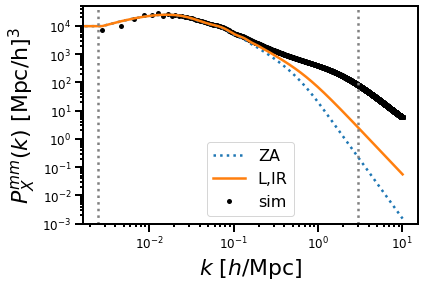

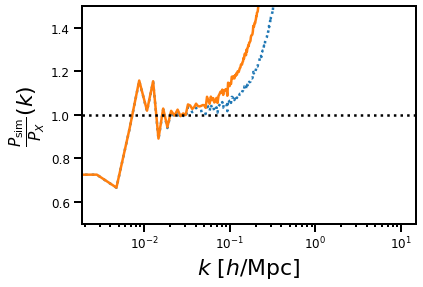

In [13]:
plt.loglog(k_sim,pzat(k_sim),ls=':',label='ZA')
plt.loglog(k_sim,plirt(k_sim),label='L,IR')
#explicitly mark boundaries of calculated values past where we are extrapolating
plt.axvline(2.5e-3,ls=':',c='gray')
plt.axvline(3,ls=':',c='gray')
plt.loglog(k_sim,Pmm_sim,ls=' ',marker='.',zorder=-1,c='k',label='sim')
plt.legend()
plt.ylim(1e-3,5e4)
plt.xlabel(r'$k \ [h/\rm{Mpc}]$')
plt.ylabel(r'$P^{mm}_{X}(k) \ [\rm{Mpc}/h]^{3}$')
plt.show()

plt.plot(k_sim,Pmm_sim/plirt(k_sim),label='X=L,IR',ls=':')
plt.plot(k_sim,Pmm_sim/pzat(k_sim),label='X=ZA')
plt.xscale('log')
plt.ylim(.5,1.5)
plt.xlabel(r'$k \ [h/\rm{Mpc}]$')
plt.ylabel(r'$\frac{P_{\rm{sim}}}{P_{X}} (k)$')
plt.axhline(1,ls=':',c='k')

In [14]:
from gzpt import bb
from scipy.optimize import curve_fit

In [22]:
def ordinary_model_nm2(k,A0,R,R1h,R1sq,R12):
    za = pzat(k)
    return  za + bb.PBB(k,[A0,R,R1h,R1sq,R12],2)

def LIR_nm2(k,A0,R,R1h,R1sq,R12):
    lir = plirt(k)
    return  lir + bb.PBB(k,[A0,R,R1h,R1sq,R12],2)

def za_transfer_model_nm1(k,alpha,A0,R,R1h):
    za = pzat(k)
    Tk = 1+alpha*k**2
    return  Tk*za + bb.PBB(k,[A0,R,R1h],1)

def LIR_transfer_model_nm1(k,alpha,A0,R,R1h):
    lir = plirt(k)
    Tk = 1+alpha*k**2
    return  Tk*lir + bb.PBB(k,[A0,R,R1h],1)

def za_transfer_model_nm2(k,alpha,A0,R,R1h,R1sq,R12):
    za = pzat(k)
    Tk = 1+alpha*k**2
    return  Tk*za + bb.PBB(k,[A0,R,R1h,R1sq,R12],2)

def LIR_transfer_model_nm2(k,alpha,A0,R,R1h,R1sq,R12):
    lir = plirt(k)
    Tk = 1+alpha*k**2
    return  Tk*lir + bb.PBB(k,[A0,R,R1h,R1sq,R12],2)

def za_transfer2_model_nm1(k,alpha,beta,A0,R,R1h):
    za = pzat(k)
    Tk = 1+alpha*k**2 + beta*k**4
    return  Tk*za + bb.PBB(k,[A0,R,R1h],1)

def LIR_transfer2_model_nm1(k,alpha,beta,A0,R,R1h):
    lir = plirt(k)
    Tk = 1+alpha*k**2 + beta*k**4
    return  Tk*lir + bb.PBB(k,[A0,R,R1h],1)

def za_transfer2_model_nm1(k,alpha,beta,A0,R,R1h):
    za = pzat(k)
    Tk = 1+alpha*k**2 + beta*k**4
    return  Tk*za + bb.PBB(k,[A0,R,R1h],1)

def LIR_transfer2_model_nm1(k,alpha,beta,A0,R,R1h):
    lir = plirt(k)
    Tk = 1+alpha*k**2 + beta*k**4
    return  Tk*lir + bb.PBB(k,[A0,R,R1h],1)

def za_transfer2(k,alpha,beta):
    za = pzat(k)
    Tk = 1+alpha*k**2 + beta*k**4
    return  Tk*za 

def LIR_transfer2(k,alpha,beta):
    lir = plirt(k)
    Tk = 1+alpha*k**2 + beta*k**4
    return  Tk*lir 

def za_transfer2_model_nm2(k,alpha,beta,A0,R,R1h,R1sq,R12):
    za = pzat(k)
    Tk = 1+alpha*k**2 + beta*k**4
    return  Tk*za + bb.PBB(k,[A0,R,R1h,R1sq,R12],2)

def LIR_transfer2_model_nm2(k,alpha,beta,A0,R,R1h,R1sq,R12):
    lir = plirt(k)
    Tk = 1+alpha*k**2 + beta*k**4
    return  Tk*lir + bb.PBB(k,[A0,R,R1h,R1sq,R12],2)

In [24]:
mask = k_sim>0.1
popt_o_nm2,_ = curve_fit(ordinary_model_nm2, k_sim[mask],Pmm_sim[mask], p0=[350,26,10,25,2],bounds = ([0,0,0,-100,1],[1.5e3,100,100,200,100]))
popt_lir_nm2,_ = curve_fit(LIR_nm2, k_sim[mask],Pmm_sim[mask], p0=[350,26,10,25,2], bounds = ([0,0,0,-100,1],[1.1e3,100,100,200,100]))

print(popt_o_nm2)
print(popt_lir_nm2)

popt_tk_o_nm1,_ = curve_fit(za_transfer_model_nm1, k_sim[mask],Pmm_sim[mask], p0=[1,350,26,10],bounds = ([-np.inf,0,0,0],[np.inf,1.5e3,100,100]))
popt_tk_lir_nm1,_ = curve_fit(LIR_transfer_model_nm1, k_sim[mask],Pmm_sim[mask], p0=[1,350,26,10], bounds = ([-np.inf,0,0,0],[np.inf,1.1e3,100,100]))

print(popt_tk_o_nm1)
print(popt_tk_lir_nm1)

popt_tk_o_nm2,_ = curve_fit(za_transfer_model_nm2, k_sim[mask],Pmm_sim[mask], p0=[1,350,26,10,25,2],bounds = ([-np.inf,0,0,0,-100,1],[np.inf,1.5e3,100,100,200,100]))
popt_tk_lir_nm2,_ = curve_fit(LIR_transfer_model_nm2, k_sim[mask],Pmm_sim[mask], p0=[1,350,26,10,25,2], bounds = ([-np.inf,0,0,0,-100,1],[np.inf,1.5e3,100,100,200,100]))

print(popt_tk_o_nm2)
print(popt_tk_lir_nm2)

popt_tk2_o_nm1,_ = curve_fit(za_transfer2_model_nm1, k_sim[mask],Pmm_sim[mask], p0=[1,1,350,26,10],bounds = ([-np.inf,-np.inf,0,0,0],[np.inf,np.inf,1.5e3,100,100]))
popt_tk2_lir_nm1,_ = curve_fit(LIR_transfer2_model_nm1, k_sim[mask],Pmm_sim[mask], p0=[1,1,350,26,10], bounds = ([-np.inf,-np.inf,0,0,0],[np.inf,np.inf,1.5e3,100,100]))

print(popt_tk2_o_nm1)
print(popt_tk2_lir_nm1)

popt_tk2_za,_ = curve_fit(za_transfer2, k_sim[mask],Pmm_sim[mask], p0=[1,1])
popt_tk2_lir,_ = curve_fit(LIR_transfer2, k_sim[mask],Pmm_sim[mask], p0=[1,1])

print(popt_tk2_za)
print(popt_tk2_lir)

popt_tk2_o_nm2,_ = curve_fit(za_transfer2_model_nm2, k_sim[mask],Pmm_sim[mask], p0=[1,1,350,26,10,25,2],bounds = ([-np.inf,-np.inf,0,0,0,-100,1],[np.inf,np.inf,1.5e3,100,100,200,100]))
popt_tk2_lir_nm2,_ = curve_fit(LIR_transfer2_model_nm2, k_sim[mask],Pmm_sim[mask], p0=[1,1,350,26,10,25,2], bounds = ([-np.inf,-np.inf,0,0,0,-100,1],[np.inf,np.inf,1.5e3,100,100,200,100]))

print(popt_tk2_o_nm2)
print(popt_tk2_lir_nm2)

[1499.99999999   17.05765872   12.5630377    70.4978625     2.646694  ]
[414.98631131  20.37872359   1.56508511   2.92087703   1.        ]
[1.22447175e+01 5.39073679e-06 9.99996527e+01 9.99999721e+01]
[ -1.35722709 625.67557998  11.59233691   0.71388712]
[ -2.26304641 948.60843268  34.59805269   4.28779893  15.30561532
   1.49038552]
[ -1.06297168 478.81599043  20.69956608   2.64271269   8.93384611
   1.32974041]
[  11.23784096    2.4196768  1499.99999934  100.           43.51447626]
[ 4.55866365e+00 -6.12380492e-02  1.18224944e+02  1.00000000e+02
  5.87417587e+00]
[11.42943757  2.38378035]
[ 4.71846173 -0.06572291]
[ 2.01183818e-01 -3.06441537e-01  1.12132650e+03  2.02778523e+01
  9.27340878e+00  4.92386421e+01  2.33870877e+00]
[-1.46932256e+00  4.42744556e-03  4.93753542e+02  2.18214859e+01
  3.03566624e+00  1.22686695e+01  1.42796258e+00]


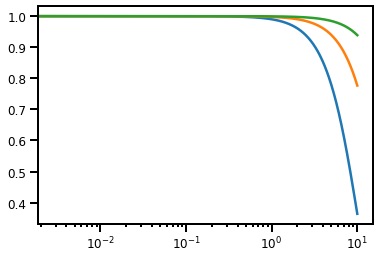

In [17]:
plt.semilogx(k_sim,np.exp(-(k_sim / 10)**2))
plt.semilogx(k_sim,np.exp(-(k_sim / 20)**2))
plt.semilogx(k_sim,np.exp(-(k_sim / 40)**2))


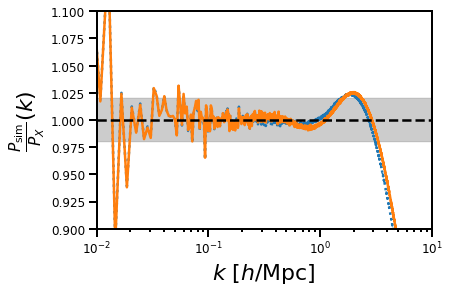

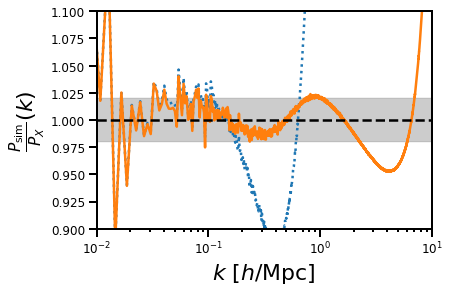

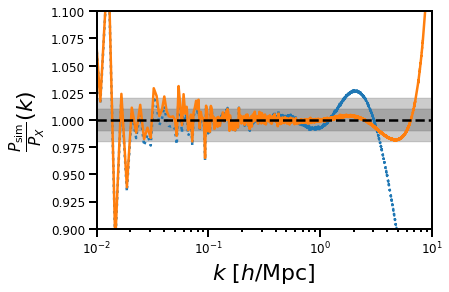

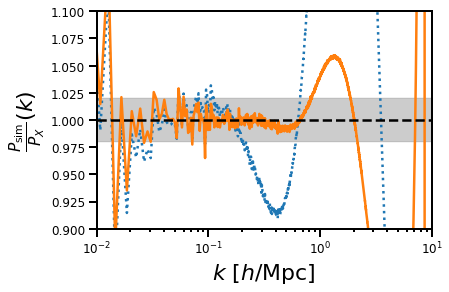

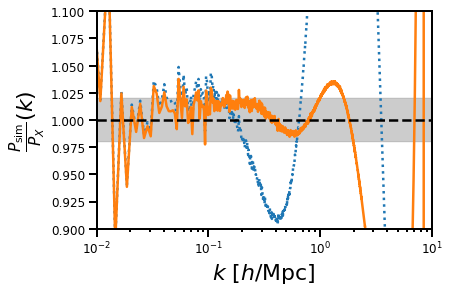

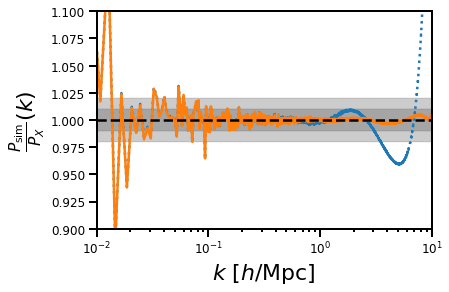

In [27]:
#nm=2 with just bb
plt.plot(k_sim,Pmm_sim/ordinary_model_nm2(k_sim,*popt_o_nm2),label='za-nm2',ls=':')
plt.plot(k_sim,Pmm_sim/LIR_nm2(k_sim,*popt_lir_nm2),label='lir-nm2')
plt.xlim(0.01,10)
plt.xscale('log')
plt.ylim(.9,1.1)
plt.fill_between(k_sim,.98,1.02,color='gray',alpha=0.4)
plt.axhline(1,ls='--',c='k')
plt.xlabel(r'$k \ [h/\rm{Mpc}]$')
plt.ylabel(r'$\frac{P_{\rm{sim}}}{P_{X}} (k)$')
plt.show()

#nm=1 with tk-alpha
plt.plot(k_sim,Pmm_sim/za_transfer_model_nm1(k_sim,*popt_tk_o_nm1),label='za-tk-nm1',ls=':')
plt.plot(k_sim,Pmm_sim/LIR_transfer_model_nm1(k_sim,*popt_tk_lir_nm1),label='lir-tk-nm1')
plt.xlim(0.01,10)
plt.xscale('log')
plt.ylim(.9,1.1)
plt.fill_between(k_sim,.98,1.02,color='gray',alpha=0.4)
plt.axhline(1,ls='--',c='k')
plt.xlabel(r'$k \ [h/\rm{Mpc}]$')
plt.ylabel(r'$\frac{P_{\rm{sim}}}{P_{X}} (k)$')
plt.show()

#nm=2 with tk-alpha - this is the best one so far
plt.plot(k_sim,Pmm_sim/za_transfer_model_nm2(k_sim,*popt_tk_o_nm2),label='za-tk-nm2',ls=':')
plt.plot(k_sim,Pmm_sim/LIR_transfer_model_nm2(k_sim,*popt_tk_lir_nm2),label='lir-tk-nm2')
plt.xlim(0.01,10)
plt.xscale('log')
plt.ylim(.9,1.1)
plt.fill_between(k_sim,.98,1.02,color='gray',alpha=0.4)
plt.fill_between(k_sim,.99,1.01,color='gray',alpha=0.5)
plt.axhline(1,ls='--',c='k')
plt.xlabel(r'$k \ [h/\rm{Mpc}]$')
plt.ylabel(r'$\frac{P_{\rm{sim}}}{P_{X}} (k)$')
plt.show()

#nm=1 with tk-alpha-beta
plt.plot(k_sim,Pmm_sim/za_transfer2_model_nm1(k_sim,*popt_tk2_o_nm1),label='za-tk2-nm1',ls=':')
plt.plot(k_sim,Pmm_sim/LIR_transfer2_model_nm1(k_sim,*popt_tk2_lir_nm1),label='lir-tk2-nm1')
plt.xlim(0.01,10)
plt.xscale('log')
plt.ylim(.9,1.1)
plt.fill_between(k_sim,.98,1.02,color='gray',alpha=0.4)
plt.axhline(1,ls='--',c='k')
plt.xlabel(r'$k \ [h/\rm{Mpc}]$')
plt.ylabel(r'$\frac{P_{\rm{sim}}}{P_{X}} (k)$')
plt.show()

#tk-alpha-beta only
plt.plot(k_sim,Pmm_sim/za_transfer2(k_sim,*popt_tk2_za),label='za-tk2',ls=':')
plt.plot(k_sim,Pmm_sim/LIR_transfer2(k_sim,*popt_tk2_lir),label='lir-tk2')
plt.xlim(0.01,10)
plt.xscale('log')
plt.ylim(.9,1.1)
plt.fill_between(k_sim,.98,1.02,color='gray',alpha=0.4)
plt.axhline(1,ls='--',c='k')
plt.xlabel(r'$k \ [h/\rm{Mpc}]$')
plt.ylabel(r'$\frac{P_{\rm{sim}}}{P_{X}} (k)$')
plt.show()

#nm=2 with tk-alpha-beta - going ham (this is the same cost as nmax=3 but gets us to k=10)
plt.plot(k_sim,Pmm_sim/za_transfer2_model_nm2(k_sim,*popt_tk2_o_nm2),label='za-tk2-nm2',ls=':')
plt.plot(k_sim,Pmm_sim/LIR_transfer2_model_nm2(k_sim,*popt_tk2_lir_nm2),label='lir-tk2-nm2')
plt.xlim(0.01,10)
plt.xscale('log')
plt.ylim(.9,1.1)
plt.fill_between(k_sim,.98,1.02,color='gray',alpha=0.4)
plt.fill_between(k_sim,.99,1.01,color='gray',alpha=0.5)

plt.axhline(1,ls='--',c='k')
plt.xlabel(r'$k \ [h/\rm{Mpc}]$')
plt.ylabel(r'$\frac{P_{\rm{sim}}}{P_{X}} (k)$')
plt.show()